<a href="https://colab.research.google.com/github/livcristi/CVDL_project/blob/main/CVDL_Project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchvision.transforms import ToTensor
# To download the dataset
from PIL import Image
from google.colab import drive, files
drive.mount('/content/gdrive/', force_remount=True)
%cd gdrive/MyDrive

Mounted at /content/gdrive/
/content/gdrive/MyDrive


In [ ]:
!unzip "/content/gdrive/MyDrive/Datasets/UC_Merced.zip" -d "/content"

In [ ]:
%cd /content

/content


In [ ]:
# Have the image labels and the path for download
_LABELS = [
    "agricultural",
    "airplane",
    "baseballdiamond",
    "beach",
    "buildings",
    "chaparral",
    "denseresidential",
    "forest",
    "freeway",
    "golfcourse",
    "harbor",
    "intersection",
    "mediumresidential",
    "mobilehomepark",
    "overpass",
    "parkinglot",
    "river",
    "runway",
    "sparseresidential",
    "storagetanks",
    "tenniscourt",
]
_IMAGE_PATH = 'UC_Merced/UCMerced_LandUse/Images'

In [ ]:
# Seed everything
import os 
import random

DEFAULT_RANDOM_SEED = 2023

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# torch random seed
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# basic + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

seedEverything()

In [ ]:
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

# Transformer used for making an image into a square
class SquarePad:
  def __call__(self, image):
    pay, width, height = image.shape
    if width > height:
      padding = (0, 0, 0, width - height)
    else:
      padding = (0, height - width, 0, 0)
    return F.pad(image, padding)

In [ ]:
# Create a transform to resize and normalize the images (using the ImageNet mean and std)
image_size = 256
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
dataset_transform = transforms.Compose([
    SquarePad(),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.Normalize(mean, std)
])

In [ ]:
# Create the dataset based on UcMerced
class UcDataset(Dataset):
  def __init__(self, root_dir, is_train, transforms=None):
    self.root_dir = root_dir
    self.is_train = is_train
    self.label_names = _LABELS
    self.transforms = transforms

    self.images = []
    self.labels = []
    self.grouped_data = {}

    # Save the image paths and their labels
    for label_index, label in enumerate(self.label_names):
      for index in range(100):
        if index < 10:
          img_name = label + '0' + str(index) + '.tif'
        else:
          img_name = label + str(index) + '.tif'
        self.images.append(os.path.join(root_dir, label, img_name))
        self.labels.append(label_index)
    
    # Group the images by the labels
    self._group_data()

    # Retrieve the images from disk (this was added later. It consumes more memory, 
    # but it leads to x2-3 less time per train epoch)
    self._retrieve_images()

  def _group_data(self):
    # Get the targets of the dataset
    np_arr = np.array(self.labels)
    # Group data images based on class
    self.grouped_data = {}
    for index in range(len(self.label_names)):
      self.grouped_data[index] = np.where((np_arr == index))[0]
  
  def _retrieve_images(self):
    # Retrieve the actual images
    self.actual_images = []
    for image_path in self.images:
      # Open the image and convert it to a numpy array
      image_data = np.array(Image.open(image_path))
      # Transpose the image, for PyTorch (C x H x W)
      image_data = image_data.transpose((2, 0, 1))
      # Convert to PyTorch tensor
      image_data = torch.from_numpy(np.array(image_data))
      self.actual_images.append(image_data.float())

  def __len__(self):
    if self.is_train:
      return 10000
    else:
      return 1000
  
  def __getitem__(self, index):    
    if index % 2 == 0:
      # Return two images from the same class
      choose_class = random.sample(range(len(self.label_names)), 1)[0]
      image_index1, image_index2 = self._extract_random_class_image(choose_class, 2)
      # Pick a positive target (1)
      target = torch.tensor(1, dtype=torch.float)
    else:
      # Return two images from different classes
      first_class, second_class = random.sample(range(len(self.label_names)), 2)
      image_index1 = self._extract_random_class_image(first_class, 1)[0]
      image_index2 = self._extract_random_class_image(second_class, 1)[0]
      # Pick a negative target (0)
      target = torch.tensor(0, dtype=torch.float)

    # Get the images
    image_1 = self.actual_images[image_index1]
    image_2 = self.actual_images[image_index2]

    # Transform the image
    if self.transforms is not None:
      image_1 = self.transforms(image_1)
      image_2 = self.transforms(image_2)

    return image_1, image_2, target
  
  def _extract_random_class_image(self, class_index, no_images):
    # Select the train/test pool
    # The test pool is made from the first 10 images from each class, while
    # the train pool is made from the rest of the images
    if self.is_train:
      pool_data = self.grouped_data[class_index][10:]
    else:
      pool_data = self.grouped_data[class_index][:10]
    
    # Pick random indexes for the given class
    return np.random.choice(pool_data, no_images, False)
  
  def get_test_images(self):
    # This is used to get all the images in the test set, not the pairs
    test_images = []

    for class_index in range(len(self.label_names)):
      for image_index in self.grouped_data[class_index][:10]:
        test_images.append(self.actual_images[image_index])
    
    return test_images

  def test_same_class(self, image_index_1, image_index_2):
    # This is used to check if two test images belong to the same class
    return ((image_index_1 // 10) == (image_index_2 // 10)) 

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Get resnet model
        self.resnet = torchvision.models.resnet18(pretrained=False)

        self.fc_in_features = self.resnet.fc.in_features
        
        # Remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # Add a fully connected layer to compute the image features
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 32),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)
    
    def init_weights(self, m):
      if isinstance(m, nn.Linear):
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class SiameseNetwork_18(nn.Module):
    def __init__(self):
        super(SiameseNetwork_18, self).__init__()
        # Get resnet model
        self.resnet = torchvision.models.resnet18(pretrained=True)

        self.fc_in_features = self.resnet.fc.in_features
        
        # Remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # Add a fully connected layer to compute the image features
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 32),
        )

        # Initialize the weights
        self.freeze_weights()
        self.fc.apply(self.init_weights)
    
    def freeze_weights(self):
      for param in self.resnet.parameters():
        param.requires_grad = False

    def init_weights(self, m):
      if isinstance(m, nn.Linear):
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)

    def forward_once(self, x):
        # Run the given data through the resnet model and the fc layer  
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class SiameseNetwork_50(nn.Module):
    def __init__(self):
        super(SiameseNetwork_50, self).__init__()
        # Get resnet model
        self.resnet = torchvision.models.resnet50(pretrained=True)

        self.fc_in_features = self.resnet.fc.in_features
        
        # Remove the last layer of resnet50 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # Add a fully connected layer to compute the image features
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 32),
        )

        # Initialize the weights
        self.freeze_weights()
        self.fc.apply(self.init_weights)
    
    def freeze_weights(self):
      for param in self.resnet.parameters():
        param.requires_grad = False

    def init_weights(self, m):
      if isinstance(m, nn.Linear):
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)

    def forward_once(self, x):
        # Run the given data through the resnet model and the fc layer  
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
# define some constants
BATCH_SIZE = 64
TEST_BATCH_SIZE = 10
EPOCHS = 21
LR = 0.01
MARGIN = 2.0
NO_CUDA = False
NO_MPS = False
DRY_RUN = False
LOG_INTERVAL = 30
SAVE_MODEL = True

In [ ]:
import torch.nn.functional as F

# Contrastive loss function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=MARGIN):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        square_distance = torch.pow(euclidean_distance, 2)
        square_margin = torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)

        loss_contrastive = torch.mean((label) * square_distance + (1 - label) * square_margin)

        return loss_contrastive

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_closest_indices(arr, value, n):
    # Method used to find the nearest n neighbours of a value in an array arr
    neighbours = NearestNeighbors(n_neighbors=n)
    neighbours.fit(arr)
    distances, indices = neighbours.kneighbors(value.reshape(1, -1))
    return indices[0]

def top5accuracy(model, device, dataset):
  # Method used to compute the top 5 accuracy for a given model (using the test data from the given dataset)
  image_values = []
  accuracy = 0

  with torch.no_grad():
    for image_data in dataset.get_test_images():
      test_image_tt = image_data.unsqueeze(0) # Add to batch
      test_image_tt = test_image_tt.to(device) # Place image on device
      image_values.append(model.forward_once(test_image_tt).cpu().data.numpy())

    batch_data = np.array(image_values).squeeze()

    for index, image_value in enumerate(image_values):
      # Find the closest 5 images to the given image 
      closest_indices = find_closest_indices(batch_data, image_value, 5)

      # Find how many neighbours are from the same class
      current_relevant = sum(dataset.test_same_class(img_index, index) for img_index in closest_indices)
      accuracy += current_relevant
    
    average_accuracy = (accuracy / len(image_values)) / 5 * 100.
    return average_accuracy

In [ ]:
from sklearn.metrics import f1_score

def train(model, device, train_loader, optimizer, epoch, train_results):
    # Train loop
    model.train()

    accumulated_loss = 0
    criterion = ContrastiveLoss()

    for batch_idx, (images_1, images_2, targets) in enumerate(train_loader):
      # Get the two images + the target batches from the data loader
      images_1 = images_1.float()
      images_2 = images_2.float()
      images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)

      optimizer.zero_grad()
      output1, output2 = model(images_1, images_2)
      loss = criterion(output1, output2, targets)
      loss.backward()
      
      # Sum the loss
      accumulated_loss += loss.item()
      optimizer.step()

      # Print some status messages
      if batch_idx % LOG_INTERVAL == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\t\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(images_1), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        if DRY_RUN:
            break
    
    # Print the epoch result and append the epoch loss
    accumulated_loss /= len(train_loader)

    print('Train Epoch: {} Loss: {:.6f}'.format(epoch, accumulated_loss))
    train_results['loss'].append(accumulated_loss)


def test(model, device, test_loader, test_results):
    model.eval()
    
    test_loss = 0
    criterion = ContrastiveLoss()

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            # Get the images from the dataloader
            images_1 = images_1.float()
            images_2 = images_2.float()
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)

            output1, output2 = model(images_1, images_2)
            loss = criterion(output1, output2, targets).sum().item()
            test_loss += loss # sum up batch loss

    test_loss /= len(test_loader)
    # Compute the accuracy and save it
    accuracy = top5accuracy(model, device, test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Average Precision@5: ({:.3f}%)\n'.format(test_loss, accuracy)) # The random Precision@5 is ~27.3%

    test_results['loss'].append(test_loss)
    test_results['accuracy'].append(accuracy)

In [ ]:
# Define the datasets
train_dataset = UcDataset(root_dir=_IMAGE_PATH, is_train=True, transforms=dataset_transform)
test_dataset = UcDataset(root_dir=_IMAGE_PATH, is_train=False, transforms=dataset_transform)

In [ ]:
# Training settings
use_cuda = not NO_CUDA and torch.cuda.is_available()
use_mps = not NO_MPS and torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': BATCH_SIZE}
test_kwargs = {'batch_size': TEST_BATCH_SIZE}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

# Define the model, optimizer and scheduler
model = SiameseNetwork_50().to(device)
optimizer = optim.Adadelta(model.fc.parameters(), lr=LR, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, threshold_mode='abs')

train_results = {'loss': []}
test_results = {'loss': [], 'accuracy': []}
# Train the model for some epochs
for epoch in range(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer, epoch, train_results)
    test(model, device, test_loader, test_results)
    scheduler.step(test_results['loss'][-1])

    # Save the model from time to time
    if SAVE_MODEL and epoch % 5 == 0:
        model_save_name = "siamese_network_50_" + str(epoch) + ".pt"
        torch.save(model.state_dict(), model_save_name)
        with open('results_50_' + str(epoch) + '.txt', 'w') as opt:
          opt.write(str(train_results))
          opt.write('\n')
          opt.write(str(test_results))

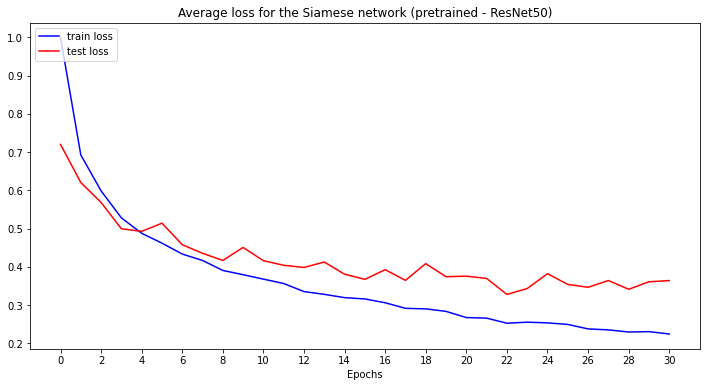

In [ ]:
import matplotlib.ticker as mticker

# Plot the loss
plt.figure(figsize=(12, 6))
plt.plot(train_results['loss'], '-b', label='train loss')
plt.plot(test_results['loss'], '-r', label='test loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
plt.xlabel("Epochs")
plt.legend(loc='upper left')
plt.title('Average loss for the Siamese network (pretrained - ResNet50)')

plt.show()

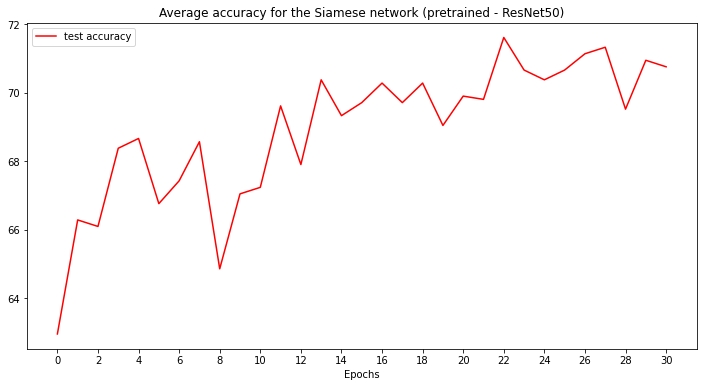

In [ ]:
import matplotlib.ticker as mticker

# Plot the accuracy
plt.figure(figsize=(12, 6))
plt.plot(test_results['accuracy'], '-r', label='test accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
plt.xlabel("Epochs")
plt.legend(loc='upper left')
plt.title('Average accuracy for the Siamese network (pretrained - ResNet50)')

plt.show()